In [1]:
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import date, datetime, timedelta

import yfinance as yf
from Historic_Crypto import HistoricalData
from scripts.params import COIN_API

# Fear and Greed Index API

Free API that provides one FNG index per day.

`'time_until_update'` value - present only for the last output 

* API just for Bitcoin - take into account for other coins prediction

 **What this index includes?**
* Volatility = 25%
* Market Momentum/Volume = 25%
* Social Media (twitter & reddit) = 15%
* Surveys (currently posed) = 15%
* Dominance (based on Bitcoin) = 10%
* Trends = 10%

In [2]:
url = 'https://api.alternative.me/fng/'
params = {'limit': 100000,
          'date_format': 'world'
         }
response = requests.get(url, params).json()


In [3]:
fng_df = pd.DataFrame(response['data']).drop(columns='time_until_update')
fng_df

,value,value_classification,timestamp
0,56,Greed,06-02-2023
1,58,Greed,05-02-2023
2,58,Greed,04-02-2023
3,60,Greed,03-02-2023
4,60,Greed,02-02-2023
...,...,...,...
1824,11,Extreme Fear,05-02-2018
1825,24,Extreme Fear,04-02-2018
1826,40,Fear,03-02-2018
1827,15,Extreme Fear,02-02-2018


In [4]:
fng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   value                 1829 non-null   object
 1   value_classification  1829 non-null   object
 2   timestamp             1829 non-null   object
dtypes: object(3)
memory usage: 43.0+ KB


In [5]:
fng_df.timestamp = pd.to_datetime(fng_df.timestamp, format='%d-%m-%Y')
fng_df.set_index('timestamp', inplace=True)

In [6]:
fng_df.rename(columns={'value': 'fng_idx', 'value_classification': 'fng_class'}, inplace=True)
fng_df

,fng_idx,fng_class
timestamp,,
2023-02-06,56,Greed
2023-02-05,58,Greed
2023-02-04,58,Greed
2023-02-03,60,Greed
2023-02-02,60,Greed
...,...,...
2018-02-05,11,Extreme Fear
2018-02-04,24,Extreme Fear
2018-02-03,40,Fear


Getting the last datapoint date of fng index and transforming it into string to use it further for rate exchanges requests

In [7]:
# changing the format of the date
fng_first_timestamp = fng_df.index[-1].date().strftime('%Y-%m-%d')
print(f'The first datapoint for fng index is {fng_first_timestamp}')

The first datapoint for fng index is 2018-02-01


In [8]:
# changing the format of the date
fng_last_timestamp = fng_df.index[0].date().strftime('%Y-%m-%d')
print(f'The last datapoint for fng index is {fng_last_timestamp}')

The last datapoint for fng index is 2023-02-06


In [9]:
#changing datatype
fng_df.fng_idx = fng_df.fng_idx.astype('float')

In [10]:
fng_df.head()

,fng_idx,fng_class
timestamp,,
2023-02-06,56.0,Greed
2023-02-05,58.0,Greed
2023-02-04,58.0,Greed
2023-02-03,60.0,Greed
2023-02-02,60.0,Greed


In [11]:
fng_df.dtypes

fng_idx      float64
fng_class     object
dtype: object

## SHORT EDA

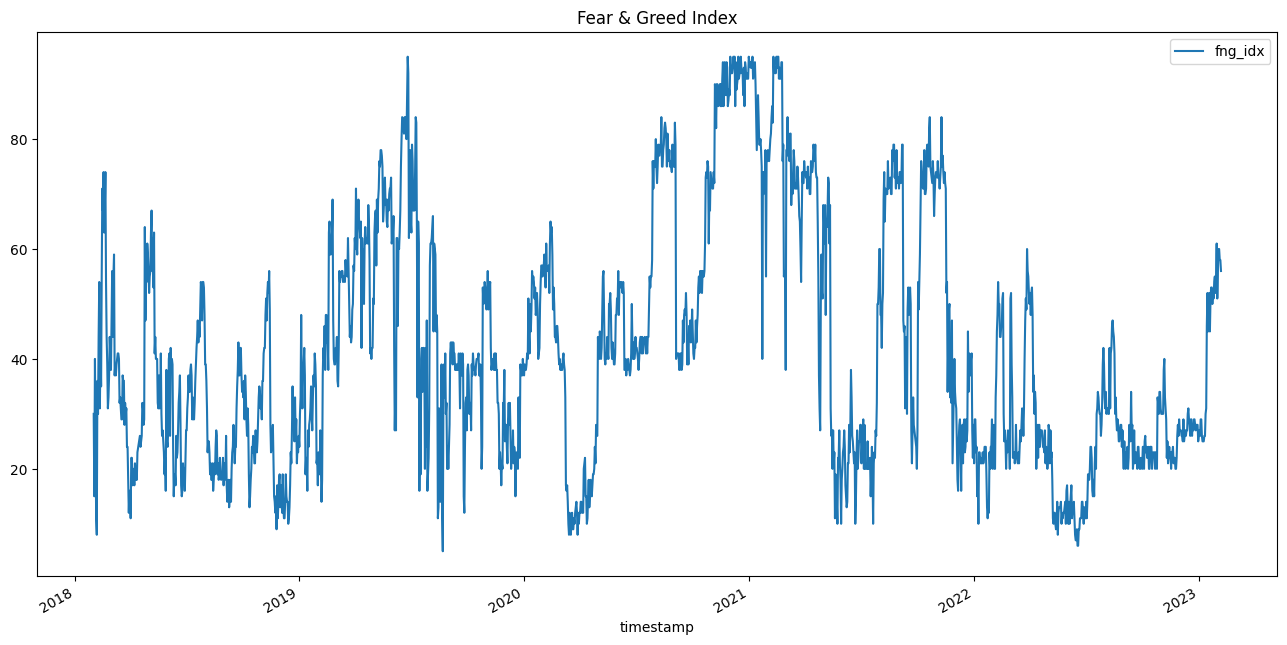

In [12]:
# fluctuation of fear and greed index
fng_df.plot(y='fng_idx', use_index=True, figsize=(16,8), title='Fear & Greed Index');

In [13]:
#minimal value 
min_val = fng_df[fng_df.fng_idx == fng_df.fng_idx.min()]
min_val
print(f"{min_val.fng_class[0]} with fng index of {min_val.fng_idx[0]} was measured on the {min_val.index[0].date().strftime('%Y-%m-%d')}.")

Extreme Fear with fng index of 5.0 was measured on the 2019-08-22.


In [14]:
# maximal values
max_val = fng_df[fng_df.fng_idx == fng_df.fng_idx.max()]
max_val

,fng_idx,fng_class
timestamp,,
2021-02-17,95.0,Extreme Greed
2021-02-16,95.0,Extreme Greed
2021-02-14,95.0,Extreme Greed
2021-02-09,95.0,Extreme Greed
2021-01-06,95.0,Extreme Greed
2020-12-31,95.0,Extreme Greed
2020-12-18,95.0,Extreme Greed
2020-12-14,95.0,Extreme Greed
2020-12-08,95.0,Extreme Greed


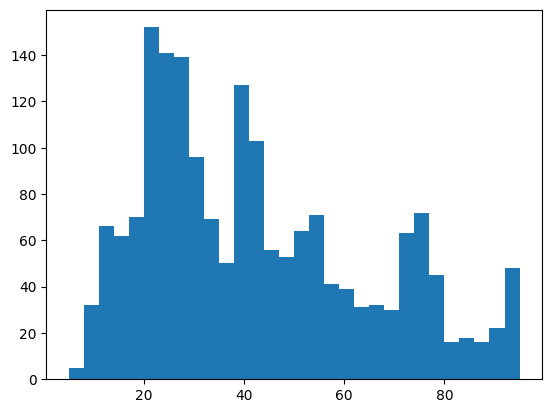

In [15]:
# index distribution 
plt.hist(fng_df.fng_idx, bins=30);

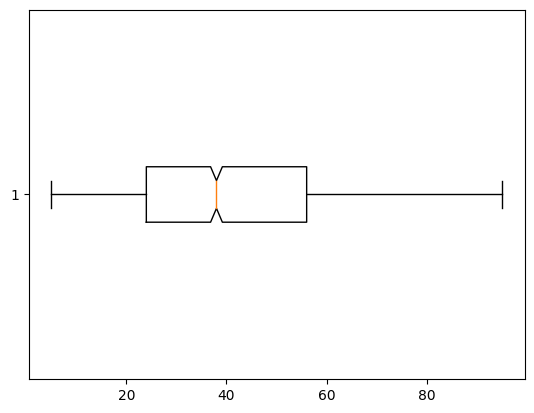

In [16]:
plt.boxplot(fng_df.fng_idx, notch=True, vert=False);

In [17]:
print(f"""
          The minimal index : {fng_df.fng_idx.min()} \n
          the maximum index : {fng_df.fng_idx.max()} \n
          the median index  : {fng_df.fng_idx.median()} \n
          the mean index    : {fng_df.fng_idx.mean().round()} """)




          The minimal index : 5.0 

          the maximum index : 95.0 

          the median index  : 38.0 

          the mean index    : 42.0 


## Variation of index

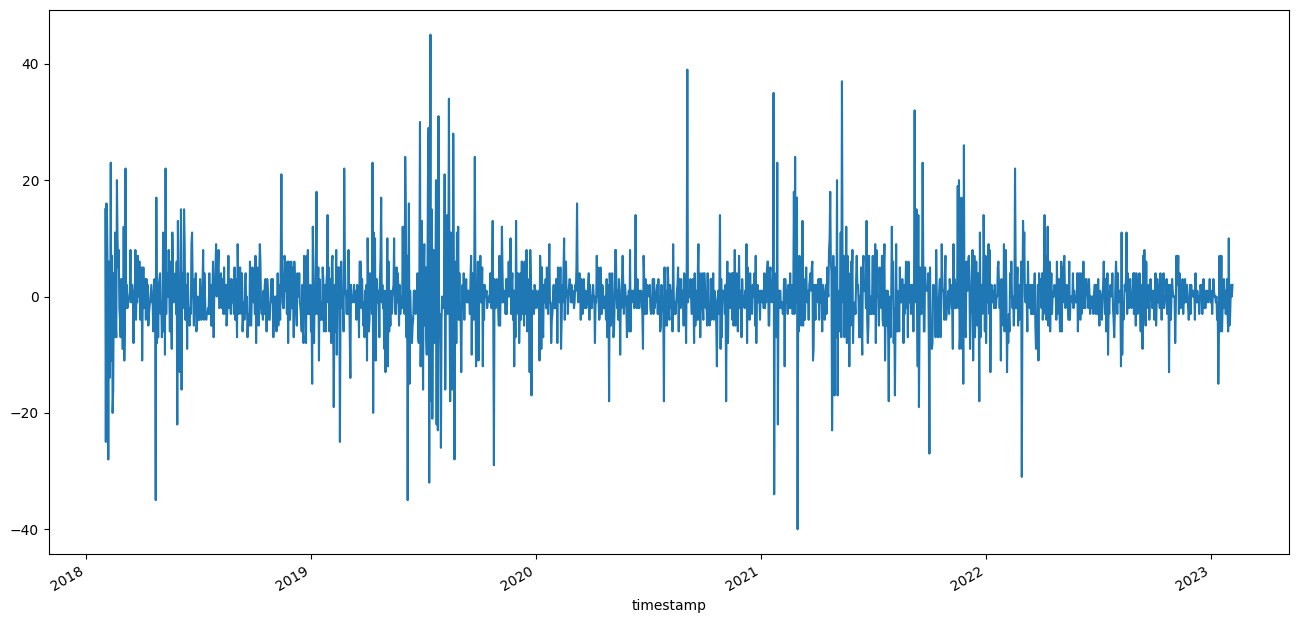

In [18]:
fng_df.fng_idx.diff(periods=1).plot(figsize=(16,8));

Variation is quite random.

In [19]:
#fng_var = pd.DataFrame(fng_df.fng_idx.diff(periods=1)).dropna().sort_values(by='value')
#fng_var

Autocorrelation is high and decreases slowly. Which is normal because the changes from day to day are not extreme.

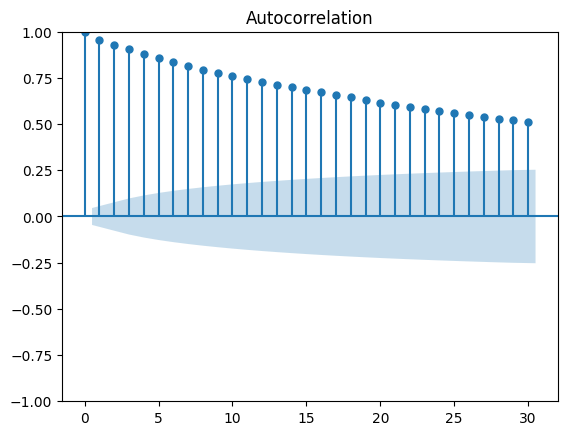

In [20]:
# autocorrealtion
plot_acf(fng_df.fng_idx, lags=30);

The partial correlation is strong with d-1 and also d-2. Next days are statistically insignificant because they are within the confidence interval. Maybe an indicator for prediciton timegap.

/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


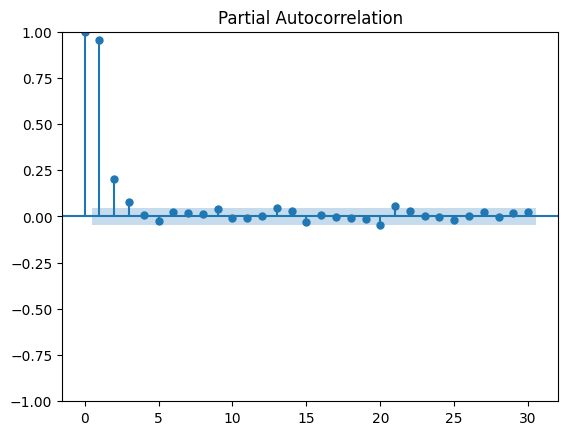

In [21]:
plot_pacf(fng_df.fng_idx, lags=30);

## In terms of emotion classes

In [22]:
# the most frequent emotions felt
fng_freq = fng_df.groupby('fng_class').count().sort_values(by='fng_idx', ascending=False)
fng_freq

,fng_idx
fng_class,
Fear,640
Extreme Fear,528
Greed,313
Extreme Greed,185
Neutral,163


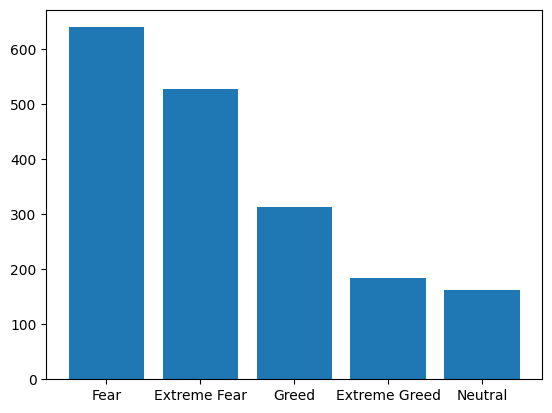

In [23]:
plt.bar(fng_freq.index, fng_freq.fng_idx);

In [24]:
print(f"""From {fng_first_timestamp} till {fng_last_timestamp}: \n
      the most frequent emotion was {fng_freq.index[0]} which was measured on {fng_freq.fng_idx[0]} days\n
      the least frequent emotion was {fng_freq.index[-1]}  which was measured on {fng_freq.fng_idx[-1]} days.""")

From 2018-02-01 till 2023-02-06: 

      the most frequent emotion was Fear which was measured on 640 days

      the least frequent emotion was Neutral  which was measured on 163 days.


# Historical data

Library that provides historical crypto data

**quite slow comparing to api**

In [25]:
dataset = HistoricalData(start_date = '2023-01-01-05-05',
                        ticker = 'BTC-USD',
                        granularity=86400,
                        verbose = False).retrieve_data()
dataset

,low,high,open,close,volume
time,,,,,
2023-01-02,16542.52,16789.99,16611.90,16666.95,13560.460180
2023-01-03,16600.00,16772.30,16666.86,16669.47,17612.355277
2023-01-04,16645.87,16988.00,16668.95,16844.42,25922.706806
2023-01-05,16750.07,16872.13,16844.40,16825.69,14918.229133
2023-01-06,16670.82,17027.11,16825.53,16948.06,24235.387042
2023-01-07,16903.58,16977.76,16948.00,16942.37,5680.117994
2023-01-08,16910.41,17167.52,16942.37,17125.18,9195.459854
2023-01-09,17102.97,17396.25,17125.17,17177.98,33252.154359
2023-01-10,17145.10,17494.37,17177.94,17443.50,24901.574858


# COIN API

can get just 580 datapoint by 1 request

In [26]:
today = date.today()
today = today.strftime('%Y-%m-%d')
today

'2023-02-06'

In [27]:
API_KEY = COIN_API

period_id = '1DAY'
asset_id_base = 'BTC'
asset_id_quote = 'USD'


time = 'T00:00:00'
time_start = f'{fng_first_timestamp}{time}'
time_end = f'{fng_last_timestamp}{time}'

limit=100000


In [28]:
url = f'https://rest.coinapi.io/v1/exchangerate/{asset_id_base}/{asset_id_quote}/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
headers = {'X-CoinAPI-Key' : API_KEY} 
response = requests.get(url, headers=headers).json()

In [29]:
df = pd.DataFrame(response).drop(columns=['time_period_end', 'time_open', 'time_close'])
df['time_period_start'] = df['time_period_start'].apply(lambda x: x[:10])
df['time_period_start'] =  pd.to_datetime(df['time_period_start'], format='%Y-%m-%d')
df.set_index('time_period_start', inplace=True)
df


,rate_open,rate_high,rate_low,rate_close
time_period_start,,,,
2018-02-01,10115.117507,10159.478682,8449.798623,9041.746815
2018-02-02,9008.078116,9069.258639,7568.776591,8797.092612
2018-02-03,8803.984327,9457.891482,8141.028790,9203.247009
2018-02-04,9158.556949,9339.265715,7848.718987,8158.506315
2018-02-05,8192.982043,8334.261876,6479.390379,6893.694242
...,...,...,...,...
2019-08-30,9521.458501,9678.536959,9349.915257,9576.181387
2019-08-31,9579.247704,9689.081497,9441.109566,9601.018063
2019-09-01,9589.693935,9818.289084,9563.743307,9763.910907


## Yfinance library

In [30]:
data = yf.download('BTC-USD', start=fng_first_timestamp, end=fng_last_timestamp, interval = '1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-01 00:00:00+00:00,10237.299805,10288.799805,8812.280273,9170.540039,9170.540039,9959400448
2018-02-02 00:00:00+00:00,9142.280273,9142.280273,7796.490234,8830.750000,8830.750000,12726899712
2018-02-03 00:00:00+00:00,8852.120117,9430.750000,8251.629883,9174.910156,9174.910156,7263790080
2018-02-04 00:00:00+00:00,9175.700195,9334.870117,8031.220215,8277.009766,8277.009766,7073549824
2018-02-05 00:00:00+00:00,8270.540039,8364.839844,6756.680176,6955.270020,6955.270020,9285289984
...,...,...,...,...,...,...
2023-02-01 00:00:00+00:00,23137.835938,23764.539062,22877.750000,23723.769531,23723.769531,26683255504
2023-02-02 00:00:00+00:00,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,32066936882
2023-02-03 00:00:00+00:00,23469.412109,23678.103516,23279.955078,23449.322266,23449.322266,27083066007


df_rate = df_rate.rename(columns={'Close':'close'}, inplace=True)
df_rate

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1831 entries, 2018-02-01 00:00:00+00:00 to 2023-02-05 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1831 non-null   float64
 1   High       1831 non-null   float64
 2   Low        1831 non-null   float64
 3   Close      1831 non-null   float64
 4   Adj Close  1831 non-null   float64
 5   Volume     1831 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 100.1 KB


In [73]:
df_rate = data[['Close', 'Volume']]
df_rate

,Close,Volume
Date,,
2018-02-01 00:00:00+00:00,9170.540039,9959400448
2018-02-02 00:00:00+00:00,8830.750000,12726899712
2018-02-03 00:00:00+00:00,9174.910156,7263790080
2018-02-04 00:00:00+00:00,8277.009766,7073549824
2018-02-05 00:00:00+00:00,6955.270020,9285289984
...,...,...
2023-01-30 00:00:00+00:00,22840.138672,27205595568
2023-01-31 00:00:00+00:00,23139.283203,22837828665
2023-02-01 00:00:00+00:00,23723.769531,26683255504


In [74]:
df_rate.reset_index(inplace=True)
df_rate = df_rate.copy()
df_rate = df_rate.rename(columns={'Date': 'timestamp', 'Close': 'rate', 'Volume': 'volume'})
df_rate

,timestamp,rate,volume
0,2018-02-01 00:00:00+00:00,9170.540039,9959400448
1,2018-02-02 00:00:00+00:00,8830.750000,12726899712
2,2018-02-03 00:00:00+00:00,9174.910156,7263790080
3,2018-02-04 00:00:00+00:00,8277.009766,7073549824
4,2018-02-05 00:00:00+00:00,6955.270020,9285289984
...,...,...,...
1824,2023-01-30 00:00:00+00:00,22840.138672,27205595568
1825,2023-01-31 00:00:00+00:00,23139.283203,22837828665
1826,2023-02-01 00:00:00+00:00,23723.769531,26683255504
1827,2023-02-02 00:00:00+00:00,23471.871094,32066936882


In [75]:
df_rate.timestamp = pd.to_datetime(df_rate.timestamp).dt.tz_localize(None)
df_rate.set_index(df_rate.timestamp, inplace=True)
df_rate.drop(columns='timestamp', inplace=True)

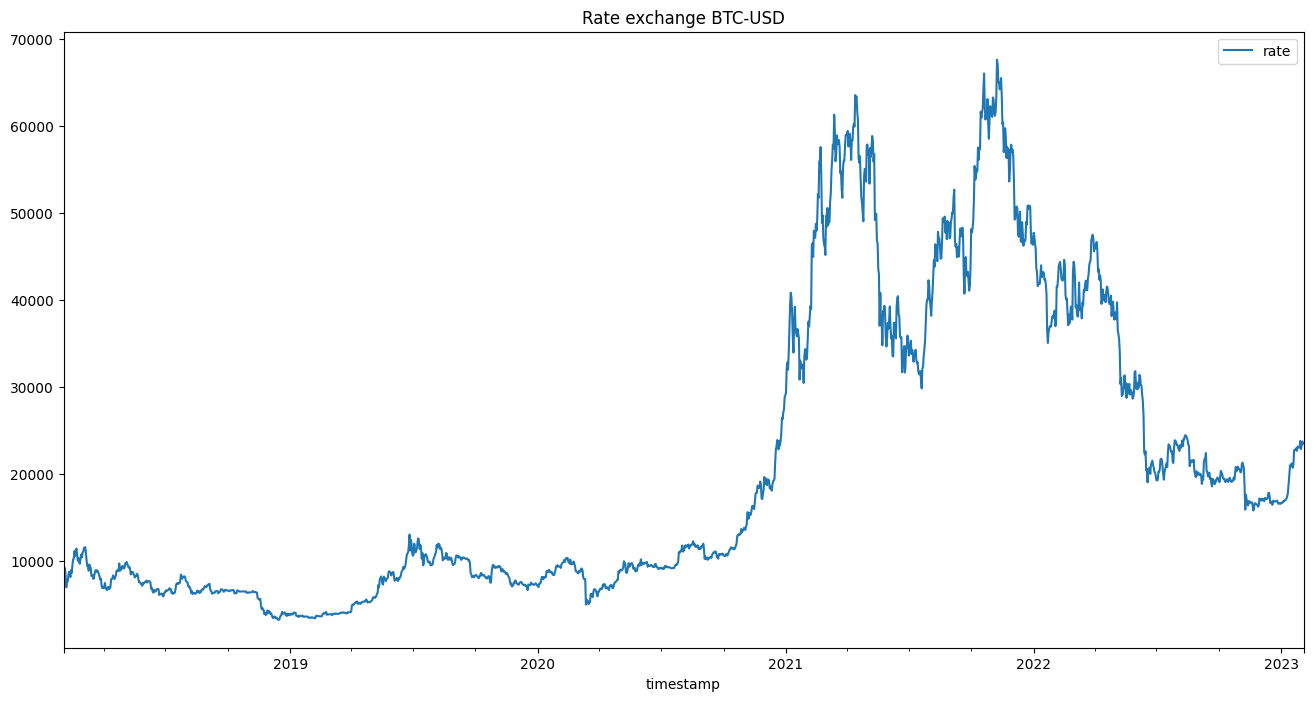

In [76]:
df_rate.plot(y='rate', use_index=True, figsize=(16,8), title='Rate exchange BTC-USD');

## Merging 2 dataframes : FNG index with rate change

In [77]:
df = fng_df.merge(df_rate, on='timestamp', how='outer').sort_index(ascending=False)
df

,fng_idx,fng_class,rate,volume
timestamp,,,,
2023-02-04,58.0,Greed,NaN,NaN
2023-02-03,60.0,Greed,23449.322266,2.708307e+10
2023-02-02,60.0,Greed,23471.871094,3.206694e+10
2023-02-01,56.0,Greed,23723.769531,2.668326e+10
2023-01-31,51.0,Neutral,23139.283203,2.283783e+10
...,...,...,...,...
2018-02-05,11.0,Extreme Fear,6955.270020,9.285290e+09
2018-02-04,24.0,Extreme Fear,8277.009766,7.073550e+09
2018-02-03,40.0,Fear,9174.910156,7.263790e+09


 3 following days do not have fng index. Will take 3 days before and 3 days after a blank period and find the mean.

In [78]:
# nan values for fng index
nan_dates = df[df.fng_idx.isnull()]
nan_dates

,fng_idx,fng_class,rate,volume
timestamp,,,,
2018-04-16,NaN,NaN,8058.669922,5.631310e+09
2018-04-15,NaN,NaN,8329.110352,5.244480e+09
2018-04-14,NaN,NaN,7986.240234,5.191430e+09


In [79]:
# the first and last date with nan value
first_nan_idx = datetime.strftime(nan_dates.index[0], format='%Y-%m-%d')
last_nan_idx = datetime.strftime(nan_dates.index[-1], format='%Y-%m-%d')

# index of the first and last date with nan value
idx_first = df.index.get_loc(first_nan_idx)
idx_last = df.index.get_loc(last_nan_idx)

mean_nan = int(df.fng_idx[idx_first-3:idx_last+4].mean())
mean_nan

22

In [80]:
df.fng_idx = df.fng_idx.replace(np.nan, mean_nan)
df[idx_first-3:idx_last+4]

,fng_idx,fng_class,rate,volume
timestamp,,,,
2018-04-19,25.0,Extreme Fear,8294.309570,7.063210e+09
2018-04-18,24.0,Extreme Fear,8163.419922,6.529910e+09
2018-04-17,26.0,Fear,7902.089844,6.900880e+09
2018-04-16,22.0,NaN,8058.669922,5.631310e+09
2018-04-15,22.0,NaN,8329.110352,5.244480e+09
2018-04-14,22.0,NaN,7986.240234,5.191430e+09
2018-04-13,23.0,Extreme Fear,7895.959961,7.764460e+09
2018-04-12,18.0,Extreme Fear,7889.250000,8.906250e+09
2018-04-11,20.0,Extreme Fear,6968.319824,4.641890e+09


In [81]:
df

,fng_idx,fng_class,rate,volume
timestamp,,,,
2023-02-04,58.0,Greed,NaN,NaN
2023-02-03,60.0,Greed,23449.322266,2.708307e+10
2023-02-02,60.0,Greed,23471.871094,3.206694e+10
2023-02-01,56.0,Greed,23723.769531,2.668326e+10
2023-01-31,51.0,Neutral,23139.283203,2.283783e+10
...,...,...,...,...
2018-02-05,11.0,Extreme Fear,6955.270020,9.285290e+09
2018-02-04,24.0,Extreme Fear,8277.009766,7.073550e+09
2018-02-03,40.0,Fear,9174.910156,7.263790e+09
